In [15]:
%matplotlib inline

In [171]:
import pandas as pd
import numpy as np


N = 100000

p0 = 0.1
p = 0.01
tau = 5

alpha_x = {0: 10, 1: 5, 2: 2}
beta_x =  {0: 1, 1: 1, 2: 1}
lambda_x = {0: 20, 1: 10, 2: 5}

x = np.random.choice([0, 1, 2], size=N)

k = [alpha_x[x_i] for x_i in x]
theta = [1. / beta_x[x_i] for x_i in x]
lambd = [lambda_x[x_i] for x_i in x]
z2 = np.random.gamma(k, theta)
z1 = np.random.poisson(lambd)

y2 = np.random.binomial(1, p=p0 * np.exp(-z2/tau))
y1 = np.random.binomial(z1, p)
y = y1 + y2

df = pd.DataFrame({'X': x, 'Y': y, 'Z_1': z1, 'Z_2': z2, 
                   'Y1': y1, 'Y2': y2})

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f235fce5208>,
      dtype=object)

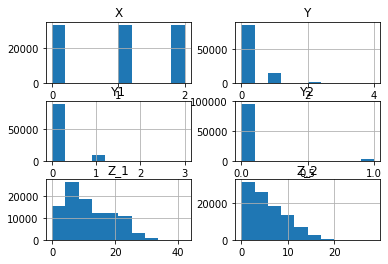

In [172]:
df.hist()

In [173]:
df.groupby('X').mean()['Y']

X
0    0.219032
1    0.140734
2    0.119037
Name: Y, dtype: float64

In [174]:
df.groupby('X').mean()[['Y1', 'Y2', 'Y']]

,Y1,Y2,Y
X,,,
0,0.202518,0.016514,0.219032
1,0.100605,0.040128,0.140734
2,0.050711,0.068326,0.119037


In [20]:
from statsmodels.api import OLS

df['expz2'] = np.exp(-z2/tau)
df['intercept'] = 1.
model = OLS(endog=df['Y'], exog=df[['expz2', 'Z_2', 'Z_1', 'X', 'intercept']])

result1 = model.fit()
df['y_given_z2_x'] = result1.predict()
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     503.6
Date:                Wed, 08 Apr 2020   Prob (F-statistic):               0.00
Time:                        17:19:17   Log-Likelihood:                -48958.
No. Observations:              100000   AIC:                         9.793e+04
Df Residuals:                   99995   BIC:                         9.797e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
expz2          0.0959      0.014      6.733      0.000       0.068       0.124
Z_2           -0.0005      0.001     -0.579      0.563      -0.002       0.001
Z_1            0.0100      0.000     28.519      0.000       0.009       0.011
X             -0.0021      0.004     -0.540      0.589      -0.010       0.005
intercept      0.0081      0.011      0.713      0.476      -0.014       0.030
==============================================================================
Omnibus:                    48712.902   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           245106.469
Skew:                           2.417   Prob(JB):                         0.00
Kurtosis:                       8.954   Cond. No.                         204.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [221]:
import keras
from keras.models import Model
from keras.layers import Dense, Input, Concatenate, Add
import tensorflow as tf


z1_in = Input(shape=(2,))
h11 = Dense(8, activation='tanh')(z1_in)
h12 = Dense(8, activation='tanh')(h11)
y1 = Dense(1, activation='exponential')(h12)

z2_in = Input(shape=(2,))
h21 = Dense(8, activation='tanh')(z2_in)
h22 = Dense(8, activation='tanh')(h21)
y2 = Dense(1, activation='exponential')(h22)


y_out = Add()([y1, y2])
#y_out = Dense(1, activation='linear')(h)


model = Model(inputs=[z1_in, z2_in], outputs=[y_out])
model.compile('RMSProp', loss='mse')

model.fit([df[['Z_1', 'X']], df[['Z_2', 'X']]], df['Y'], epochs=100, batch_size=4096)

Epoch 1/100
100000/100000 [==============================] - 0s 2us/step - loss: 1.8057
Epoch 2/100
100000/100000 [==============================] - 0s 1us/step - loss: 0.7030
Epoch 3/100
100000/100000 [==============================] - 0s 1us/step - loss: 0.3675
Epoch 4/100
100000/100000 [==============================] - 0s 1us/step - loss: 0.2348
Epoch 5/100
100000/100000 [==============================] - 0s 1us/step - loss: 0.1831
Epoch 6/100
100000/100000 [==============================] - 0s 1us/step - loss: 0.1646
Epoch 7/100
100000/100000 [==============================] - 0s 1us/step - loss: 0.1588
Epoch 8/100
100000/100000 [==============================] - 0s 1us/step - loss: 0.1571
Epoch 9/100
100000/100000 [==============================] - 0s 1us/step - loss: 0.1565
Epoch 10/100
100000/100000 [==============================] - 0s 1us/step - loss: 0.1563
Epoch 11/100
100000/100000 [==============================] - 0s 1us/step - loss: 0.1560
Epoch 12/100
100000/100000 [==

In [222]:
model = Model(inputs=[z1_in, z2_in], outputs=[y1, y2])
model.compile('RMSProp', loss='mse')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2366dd89e8>]],
      dtype=object)

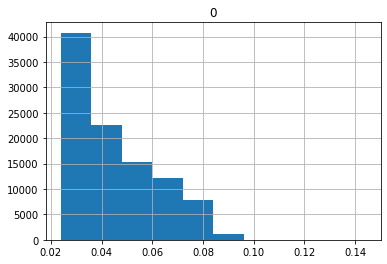

In [223]:
pd.DataFrame(model.predict([df[['Z_1', 'X']], df[['Z_2', 'X']]])[1]).hist()

In [224]:
from statsmodels.nonparametric.kernel_density import KDEMultivariateConditional

p_z1_given_x = KDEMultivariateConditional(endog=df[['Z_1']], exog=df[['X']], 
                                          dep_type='c', indep_type='u', 
                                          bw='normal_reference')

In [225]:
p_z2_given_x = KDEMultivariateConditional(endog=df[['Z_2']], exog=df[['X']], 
                                          dep_type='c', indep_type='u', 
                                          bw='normal_reference')


In [191]:
df['p_z2_given_x'] = p_z2_given_x.pdf()
df['p_z1_given_x'] = p_z1_given_x.pdf()

KeyboardInterrupt: 

In [ ]:
df[df.X==1].plot(x='Z_2', y='p_z2_given_x', kind='scatter')

In [ ]:
df[df.X==2].plot(x='Z_2', y='p_z2_given_x', kind='scatter')

In [ ]:
px = df.groupby('X').count()

In [ ]:
px / len(df)

In [226]:
from scipy.integrate import quad

def integrand(z1, x=0):
    f1 = float(p_z1_given_x.pdf(endog_predict=[z1], exog_predict=[x]))
    the_sum = 0.
    for xp in df.X.unique():
        y1 = model.predict([[[z1, xp]], [[df.Z_2.mean(), 0]]])[0][0][0]
        p_x = 1/3.
        the_sum += y1 * p_x
    return the_sum*f1
        
quad(lambda z: integrand(z, x=0.), df.Z_1.min(), df.Z_1.max())

(0.18016819189803418, 3.420985525998103e-09)

In [227]:
quad(lambda z: integrand(z, x=1.), df.Z_1.min(), df.Z_1.max())

(0.09424426943521841, 1.3560215620582093e-08)

In [228]:
quad(lambda z: integrand(z, x=2.), df.Z_1.min(), df.Z_1.max())

(0.06298908857941396, 9.869472595083272e-09)

In [229]:
from scipy.integrate import quad

def integrand(z2, x=0):
    f1 = float(p_z2_given_x.pdf(endog_predict=[z2], exog_predict=[x]))
    the_sum = 0.
    for xp in df.X.unique():
        y2 = model.predict([[[df.Z_1.mean(), 0]], [[z2, xp]]])[1][0][0]
        p_x = 1/3.
        the_sum += y2 * p_x
    return the_sum*f1
        
quad(lambda z: integrand(z, x=0.), df.Z_2.min(), df.Z_2.max())

(0.033986835933868434, 1.762487491206813e-09)

In [230]:
quad(lambda z: integrand(z, x=1.), df.Z_2.min(), df.Z_2.max())

(0.05024109200426411, 2.3963653143324222e-09)

In [231]:
quad(lambda z: integrand(z, x=2.), df.Z_2.min(), df.Z_2.max())

(0.07915992039444318, 2.410230366131944e-09)